# TP3 CompStats

**David Soto**

# Exercice 1

# 1.A. A population model for longitudinal data

**Question 1**

Voir pdf.

**Question 2**

N.B. : Pour une question de simplicité, tout au long de ce script j'utilise la notation sigma = $\sigma^2$, sigmaksi = $\sigma_{\xi}^2$, sigmatau = $\sigma_{\tau}^2$, sv0 = $s_{v0}^2$ etc ... Ainsi que v = $v^2$, vksi = $v_{xi}^2$, etc... Ceci m'évite d'écrire "sigma^2, etc..." ou encore "v^2" à chaque fois.

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# On pose sigmap0, sigmat0 égaux à 1 et sigmav0 = 0.5
sigmap0 = 1 
sigmat0 = 1
sigmav0 = 0.5
# On pose st0 & sv0 égaux à 1
st0 = 1
sv0 = 1
# On pose t02bar = v02bar = 0
t02bar = 0
v02bar = 0
# On pose p0bar = 0 et on définie t0bar & v0bar
p0bar = 0 
t0bar = np.random.normal(loc=t02bar, scale=1.0, size=None)
v0bar = np.random.normal(loc=v02bar, scale=1.0, size=None)
# On définie maintenant p0, t0 & v0
p0 = np.random.normal(loc=p0bar, scale=1.0, size=None)
t0 = np.random.normal(loc=t0bar, scale=1.0, size=None)
v0 = np.random.normal(loc=v0bar, scale=0.5, size=None)

In [20]:
def d(t) :
  return p0 + v0 * (t - t0)

In [21]:
# On définie les paramètres
N = 100
sigma = 0.5
sigmaksi = 1
sigmatau = 0.8

# On génère les suites iid ksi, tau et alpha :
#epsilon = np.random.normal(loc=0.0, scale=sigma, size=N)
ksi = np.random.normal(loc=0.0, scale=sigmaksi, size=N)
tau = np.random.normal(loc=0.0, scale=sigmatau, size=N)
alpha = np.exp(ksi)

In [22]:
# Pour plus de simplicité, on suppose que tout les ki sont égaux à k = 10
k = 10

# On génère notre suite espilon_ij
epsilon = []
for n in range(N) :
  eps = np.random.normal(loc=0.0, scale=sigma, size=k)
  epsilon.append(eps)
epsilon = np.array(epsilon)

# On définie les temps tij
t = []
for i in range(N) : 
  A = []
  for j in range(k) :
    A.append(j)
  t.append(A)
t = np.array(t)
  

In [23]:
# On peut maintenant générer les données yij
y = []
for i in range(N):
  A = []
  for j in range(k) :
    yij = p0 + v0 * (alpha[i] * (t[i][j] - t0 - tau[i])) + epsilon[i][j]
    A.append(yij)
  y.append(A)
y = np.array(y)

In [24]:
print(y.min())
print(y.max())

-18.98648065056679
41.98441328262518


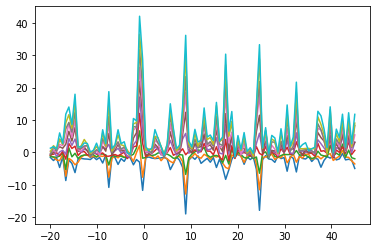

In [25]:
x  = np.linspace(-20, 45, 100)
plt.plot(x,y)
plt.show()

# 1.B. HM-SAEM – Hastings-Metropolis sampler


**Question 3**

La première partie de la réponse se trouve dans le pdf.

In [32]:
di_tij = []
for i in range(N):
  A = []
  for j in range(k) :
    dij = p0 + v0 * (alpha[i] * (t[i][j] - t0 - tau[i]))
    A.append(dij)
  di_tij.append(A)
di_tij = np.array(di_tij)

In [33]:
# On pose les paramètres des distributions inverses Wishart
m = 1
mksi = 1
mtau = 1
v = 1
vksi = 1
vtau = 1
n = 2

# On commence par définir les fonctions qui nous permettront de calculer la log-vraisemblance
def S(y, t0, v0, ksi, tau) :
  S1 = (1/N) * np.sum((y-di_tij)**2)
  S2 = (1/n) * np.sum(tau**2)
  S3 = (1/n) * np.sum(ksi**2)
  S4 = t0
  S5 = v0
  VecS = []
  VecS.append(S1)
  VecS.append(S2)
  VecS.append(S3)
  VecS.append(S4)
  VecS.append(S5)
  return VecS

def phi(t0bar,v0bar,sigmaksi,sigmatau,sigma) :
  phi1 = -(N/(2*sigma))
  phi2 = -(n/(2*sigmatau))
  phi3 = -(n/(2*sigmaksi))
  phi4 = t0bar/sigmat0
  phi5 = v0bar/sigmav0
  phi = []
  phi.append(phi1)
  phi.append(phi2)
  phi.append(phi3)
  phi.append(phi4)
  phi.append(phi5)
  return phi

def psi(t0bar,v0bar,sigmaksi,sigmatau,sigma) :
  T1 = -(N/2) * np.log(sigma) - (n/2)*np.log(sigmaksi) - (n/2)*np.log(sigmatau) - (1/(2*sigmat0))*t0bar**2 - (1/(2*sigmav0))*v0bar**2
  T2 = -(1/(2*st0))*(t0bar-t02bar)**2 - (1/(2*sv0))*(v0bar-v02bar)**2
  T3 = -(1+(m/2))*np.log(sigma) - v/(2*sigma) -(1+(mksi/2))*np.log(sigmaksi) - vksi/(2*sigmaksi) -(1+(mtau/2))*np.log(sigmatau) - vtau/(2*sigmatau)
  return T1+T2+T3



In [34]:
# Pour rappel, le modèle étant exponentiel, on a LogL = < S, phi > + psi
# Fonction log-likelihood
def LogL(S, phi, psi) :
  A = 0
  for i in range(len(S)) :
    A = A + S[i] * phi[i]
  #N.B : il faut ajouter la constante psi et les termes que nous avions enlevé pour la question 1, comme suit :
  A = A + psi - (N/2)*np.log(2*np.pi) - (n/2)*np.log(2*np.pi) - (n/2)*np.log(2*np.pi) - (1/2)*np.log(2*np.pi) - (1/2)*np.log(2*np.pi)
  A = A - (1/2)*np.log(st0) - (1/2)*np.log(sv0)
  return A

In [40]:
# Recall that t0 & v0 are fixed. Therefore we only need to compute ksi_i & tau_i for each z
# Define the parameters
mu = [0,0]
Sigma_prop = [[sigma, 0], [0, sigmaksi]]

# Enfin on peut définir notre algorihtme.

# Algorithme Hastings-Metropolis
def HM(nSteps) :
  z = [0,0]
  for i in range(nSteps) :
    zn = z + np.random.multivariate_normal(mu, Sigma_prop).T
    # Calcule des logq(zn,y,theta) et logq(z,y,theta)
    S1 = S(y, t0, v0, ksi, tau)
    ksi[i] = zn[0]
    tau[i] = zn[1]
    S2 = S(y, t0, v0, ksi, tau)
    phi1 = phi(t0bar,v0bar,sigmaksi,sigmatau,sigma)
    phi2 = phi(t0bar,v0bar,sigmaksi,sigmatau,sigma)
    psii = psi(t0bar,v0bar,sigmaksi,sigmatau,sigma)

    logqz = LogL(S1,phi1,psii)
    logqzn = LogL(S2,phi2,psii)

    #Calcul de log(alpha)
    logalpha = min(1, logqzn-logqz)
    u = np.log(np.random.rand()) # On prend log(u) car on a calculé log(alpha)
    if u < logalpha : 
      z = zn
    else :
      z = z
  return z

In [41]:
# On teste
nSteps = 100
z = HM(nSteps)
print(z)

[ 0.60516802 -2.84331674]


This algorithm is called Symmetric Random Walk Hasting-Metropolis algorithm.

**Question 4**

La réponse à la première partie de cette question (calcule du paramètre optimal $\theta$) se trouve dans le fichier pdf.

In [47]:
# On définie l'algorithme HM-SAEM
# On commence par définir le paramètre Burn-in
Nb = 10
Alpha = 0.5

def HM_SAEM(y, t0bar,v0bar,sigmaksi,sigmatau,sigma, maxIter):
  z = [0,0]
  Sk = [0,0,0,0,0]
  for k in range(maxIter) :
    # Simulation
    z = HM(100)
    # Stochastic Approximation
    # Step-sizes e :
    if k <= Nb : 
      e = 1
      ksi[i] = z[0]
      tau[i] = z[1]
      Syz_kplus1 = np.array(S(y, t0, v0, ksi, tau))
      Sk = Sk + e *(Syz_kplus1 - np.array(Sk))
    else :
      e = (k-Nb)**(-Alpha)
      Syz_kplus1 = np.array(S(y, t0, v0, ksi, tau))
      Sk = Sk + e *(Syz_kplus1 - np.array(Sk))
    # Maximisation 
    # On connaît l'expression du theta optimal 
    numerateur = (t0/sigmat0) + (t02bar/st0)
    denominateur = (1/sigmat0) + (1/ st0)
    t0bar = numerateur/denominateur

    numerateur = (v0/sigmav0) + (v02bar/sv0)
    denominateur = (1/sigmav0) + (1/ sv0)
    v0bar = numerateur/denominateur

    numerateur = np.sum((y-di_tij)**2) + v
    denominateur = N + 2 + m
    sigma = numerateur/denominateur

    numerateur = np.sum(ksi**2) + vksi
    denominateur = n + 2 + mksi
    sigmaksi = numerateur/denominateur

    numerateur = np.sum(tau**2) + vtau
    denominateur = n + 2 + mtau
    sigmatau = numerateur/denominateur
    
  return t0bar,v0bar,sigmaksi,sigmatau,sigma

On test l'algorithme avec nos données

In [50]:
theta = HM_SAEM(y, t0bar,v0bar,sigmaksi,sigmatau,sigma, 100)
print(theta)

(0.7368523710150081, 0.46222045707780907, 47.12874765978429, 57.749491484373245, 40.04838722747212)


In [53]:
# On affiche les vrais paramètres
print("t0bar :",t0bar)
print("v0bar :",v0bar)
print("sigmaksi :",sigmaksi)
print("sigmatau :",sigmatau)
print('sigma :', sigma)

t0bar : 0.32897457281975856
v0bar : 0.8568270176147144
sigmaksi : 1
sigmatau : 0.8
sigma : 0.5


Malheureusement l'algorithme ne fonctionne pas comme j'espérais, et je n'ai pas réussi à corriger l'erreur.

Je dois admettre que j'ai eu beaucoup de mal à faire l'exercice 1, en particulier pour la deuxième partie de l'exercice 1 sur les Gibbs sampler.

**Question 5**

Voir pdf.

**Question 6**

Voir pdf.

**Question 8**

Voir pdf.

# Exercice 2


**Question 1**

Tout d'abord, la variable $Y$ peut être exprimée de la façon suivante :

$$ Y =   \varepsilon X 1_{\mathcal{B} = 1} +  \dfrac{X}{\varepsilon} 1_{\mathcal{B} = 0} $$

On cherche à déterminer la densité de la variable $Y \sim q(X,Y)$. Pour se faire, nous allons passer par les espérances.

Soit g une fonction continue sur $\mathbb{R}$. On a clairement que : $$g(Y) = g(\varepsilon X) 1_{\mathcal{B} = 1} +  g\left(\dfrac{X}{\varepsilon}\right) 1_{\mathcal{B} = 0} $$

On a donc que l'espérance de g(Y) est donnée par :

$$ \mathbb{E}[g(Y)] = \mathbb{E}\left[ g(\varepsilon X) 1_{\mathcal{B} = 1} + g \left( \dfrac{X}{\varepsilon} \right) 1_{\mathcal{B} = 0}  \right] $$

On a par la linéarité de l'espérance :

$$ \mathbb{E}[g(Y)] = \mathbb{E} \left[ g(\varepsilon X) 1_{\mathcal{B} = 1} \right] + \mathbb{E}\left[ g \left( \dfrac{X}{\varepsilon} \right) 1_{\mathcal{B} = 0} \right] $$

$$ \mathbb{E}[g(Y)] = \frac{1}{2} \mathbb{E} \left[ g(\varepsilon X) \right] + \frac{1}{2} \mathbb{E}\left[ g \left( \dfrac{X}{\varepsilon} \right) \right] $$


On calcule la première espérance :
$$ \mathbb{E}[g(\varepsilon X)] = \int_{-1}^1 g \left( X x \right) f(x) dx $$
On fait le changement de variable $x=h(y)=\dfrac{y}{X}$. $h$ est bijective de $]−\rvert X∣,∣X∣[$ dans $]−1,1[$. 
On a donc : 

$$ \mathbb{E}[g(\varepsilon X)] = \int_{-|X|}^{|X|} g \left( y \right) f \left( \dfrac{y}{X} \right) \dfrac{1}{|X|} dy $$

On calule la deuxième espérance :

$$ \mathbb{E} \left[ g \left( \dfrac{X}{\varepsilon} \right) \right] = \int_{-1}^1 g \left( \dfrac{X}{x} \right) f(x) dx $$


On pose le changement de variable $x=h(y)=\dfrac{X}{y}$. 

* Si $X$ est positif, on a que $\left[ y \mapsto \dfrac{X}{y} \right]$ est une bijection de $]-\infty, -\rvert X \rvert[$ dans $]\dfrac{-X}{\rvert X \rvert},0[$ $=$ $]-1,0[$ et une bijection de $]\rvert X \rvert, \infty[$ dans $]0,\dfrac{X}{\rvert X \rvert}[$ $=$ $]0,1[$

* Si $X$ est négatif, on a que $\left[ y \mapsto \dfrac{X}{y} \right]$ est une bijection de $]-\infty, -\rvert X \rvert[$ dans $]0, \dfrac{-X}{\rvert X \rvert}[$ $=$ $]0,1[$ et une bijection de $]\rvert X \rvert, \infty[$ dans $]\dfrac{X}{\rvert X \rvert}, 0[$ $=$ $]-1,0[$

Ainsi, on a bien que $h$ est une bijection de ​$]-\infty, -\rvert X \rvert[$ $\cup$ $]\rvert X \rvert, \infty[$  dans  $] -1, 1 [ \setminus \{ 0 \}$. De plus, h est monotone sur ces deux intervales et : 
$$ | h'(y) | = \dfrac{|X|}{y^2}$$


On obtient alors :
$$ \mathbb{E} \left[ g \left( \dfrac{X}{\varepsilon} \right) \right] = \int_{-\infty}^{-|X|} g \left( y \right) f \left( \dfrac{X}{y} \right) \dfrac{|X|}{y^2} dy + \int_{|X|}^{\infty} g \left( y \right) f \left( \dfrac{X}{y} \right) \dfrac{|X|}{y^2} dy $$

L'espérance de $g(Y)$ est ainsi donnée par :
$$ \mathbb{E}[g(Y)] = \dfrac{1}{2} \int_{-\infty}^{-|X|} g \left( y \right) f \left( \dfrac{X}{y} \right) \dfrac{|X|}{y^2} dy + \dfrac{1}{2} \int_{-|X|}^{|X|} g \left( y \right) f \left( \dfrac{y}{X} \right) \dfrac{1}{|X|} dy + \dfrac{1}{2} \int_{|X|}^{\infty} g \left( y \right) f \left( \dfrac{X}{y} \right) \dfrac{|X|}{y^2} dy $$

On peut ainsi identifier la densité de $Y \sim q(X,Y)$ dans cette espérance. On en déduit que cette densité est donnée par  :
$$ q(X, y) = 1_{|y| > |X|} f \left( \dfrac{X}{y} \right) \dfrac{|X|}{2 y^2} + 1_{|y| < |X|} f \left( \dfrac{y}{X} \right) \dfrac{1}{2 |X|} 
 $$



**Question 2**

Par définition de l'acceptation ratio $\alpha$, on a :

$$ \alpha(x,y) = min \left( 1, \dfrac{\pi(y)q(y,x)}{\pi(x)q(x,y)} \right)$$

$$ = min \left( 1,  \dfrac{ \pi(y) 1_{|x| > |y|} f \left( \dfrac{y}{x} \right) \dfrac{|y|}{2 x^2} + 1_{|x| < |y|} f \left( \dfrac{x}{y} \right) \dfrac{1}{2 |y|}} {\pi(x) 1_{|y| > |x|} f \left( \dfrac{x}{y} \right) \dfrac{|x|}{2 y^2} + 1_{|y| < |x|} f \left( \dfrac{y}{x} \right) \dfrac{1}{2 |x|}  } \right) $$

$$= min \left( 1, \dfrac{\pi(y)}{\pi(x)} \left( 1_{|x| > |y|} \dfrac{|y|}{|x|} + 1_{|x| < |y|} \dfrac{|y|}{|x|} \right) \right)$$

$$ = min \left( 1, \dfrac{\pi(y)}{\pi(x)} \dfrac{|y|}{|x|}  \right)$$



**Question 3 & 4**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, norm, poisson

In [ ]:
def MultiplicativeHM(pi, f, nSteps) :
  X = np.random.rand()*2-1 # represents the current state of the Markov Chain, X is in ]-1,1[
  for i in range(nSteps) :
    e = f()
    B = bernoulli(.5).rvs(1)
    if B == 1 : 
      Y = e*X
    else : 
      Y = X/e
    alpha = min(1, (pi(Y)*abs(Y))/(pi(X)*abs(X))) # Nous avons calculé alpha dans la question 2
    if np.random.rand() < alpha: 
      X = Y 
  return X

Nous allons commencer par implémenter ce sampler pour la loi cible $\mathcal{N}(0,1)$.

In [ ]:
def N_zero_one(x):
  return np.exp(-0.5*x*x) / np.sqrt(2*np.pi)

unif = lambda: np.random.rand()*2-1 # unif représente la loi de epsilon, de densité f définie sur ]-1,1[

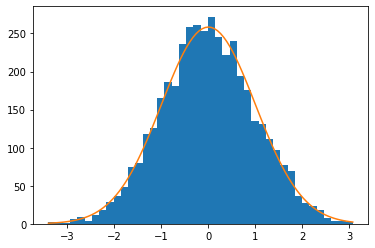

In [ ]:
n = 4200
X = [MultiplicativeHM(N_zero_one, unif, 20) for _ in range(n)]

x0, x1 = min(X), max(X)
x = np.linspace(x0, x1, 100)
density = N_zero_one(x) * 100*(x1-x0)

plt.hist(X, n//100)
plt.plot(x, density)
plt.show()

Les échantillons générer par l'algorithme multiplicative HM ont l'air de bien suivre la loi $\mathcal{N}(0,1)$.

Maintenant nous allons implémenter le multiplicative Hastings Metropolis pour la loi cible $\mathcal{Rayleigh}(4)$.

In [ ]:
# Loi de Rayleigh de paramètre sigmA = 4
sigmA = 4

def Rayleigh(x):
  return np.exp(- x**2 / (2*sigmA**2)) * (x/sigmA**2) * (x >= 0 )

def MultiplicativeHM2(pi, f, nSteps) :
  X = np.random.rand()  # represents the current state of the Markov Chain, X is in ]0,1[
  for i in range(nSteps) :
    e = f()
    B = bernoulli(.5).rvs(1)
    if B == 1 : 
      Y = e*X
    else : 
      Y = X/e
    alpha = min(1, (pi(Y)*abs(Y))/(pi(X)*abs(X)))
    if np.random.rand() < alpha: 
      X = Y 
  return X

unif = lambda: np.random.rand()*2-1  # représente la loi de epsilon, de densité f définie sur ]-1,1[

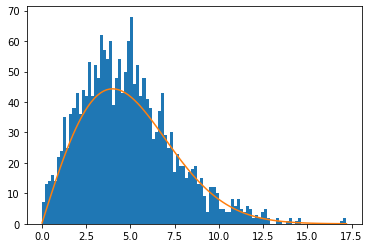

In [ ]:
n = 2000

X = [MultiplicativeHM2(Rayleigh, unif, 50) for _ in range(n)]

x0, x1 = min(X), max(X)
x = np.linspace(x0, x1, 100)
density = [Rayleigh(a) * 17 *(x1-x0) for a in x]

plt.hist(X, bins = 100)
plt.plot(x, density)
plt.show()

Les échantillons générés ont l'air de bien suivre la loi $\mathcal{Rayleigh}(4)$